In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402/FinalProject

/content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402/FinalProject


In [3]:
ls

sample_image.png  self_attention_layer1_forward.py  TestCode.ipynb


In [4]:
dir = "/content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402/FinalProject/"

In [20]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel, VisionEncoderDecoderModel, AutoTokenizer

# Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Load the image captioning model
caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
caption_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

###**Original CLIP**

In [32]:
import torch

# load image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Use CLIP to compute similarity scores for predefined captions
candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
inputs = clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
outputs = clip_model(**inputs)

# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")

# Generate a detailed caption using the captioning model
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
# generated_ids = caption_model.generate(pixel_values)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")

# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[22.7387, 15.6618, 19.7639]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a cat
Generated Caption: a cat laying on a blanket with a cat on it 
Generated Caption with CLIP influence: a photo of a cat and a cat laying on a blanket 


In [22]:
# CLIP score 게산
import torch
import torch.nn.functional as F

# 이미지 임베딩 생성
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
image_features = clip_model.get_image_features(pixel_values)

# 캡션 임베딩 생성
print(generated_caption)
text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)

# 임베딩 정규화 (벡터 길이를 1로 만듦)
image_features = F.normalize(image_features, p=2, dim=1)
text_features = F.normalize(text_features, p=2, dim=1)

# 유사도 점수 계산 (코사인 유사도)
similarity_score = (image_features @ text_features.T).item()
print(f"CLIP Similarity Score: {similarity_score}")

a photo of a cat and a cat laying on a blanket 
CLIP Similarity Score: 0.267513632774353


In [7]:
clip_model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [16]:
for name, module in clip_model.named_modules():
  print(name, module)

 CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1

In [8]:
ls

sample_image.png  self_attention_layer1_forward.py  TestCode.ipynb


In [16]:
# self_attn_layer1 = clip_model.vision_model.encoder.layers[0].self_attn
# print(self_attn_layer1)

# # k_proj와 q_proj 확인
# #print("Key Projection:", self_attn_layer1.k_proj)
# #print("Query Projection:", self_attn_layer1.q_proj.weight)

# # def hook(module, input, output):
# #     return output
# # self_attn_layer1.register_forward_hook(hook)

# # Forward 함수 확인
# import inspect
# forward_code = inspect.getsource(self_attn_layer1.forward)
# # print(forward_code)

# # 파일에 저장
# # file_name = "self_attention_layer1_forward.py"
# # with open(file_name, "w") as f:
# #     f.write(forward_code)

# # print(f"Forward code saved to {file_name}")

###Self Attention Layer의 forward 함수 수정

In [23]:
from typing import Optional, Tuple
from types import MethodType
from packaging import version
is_torch_greater_or_equal_than_2_2 = version.parse(torch.__version__) >= version.parse("2.2.0")


def forward_modified(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    causal_attention_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = False,
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    if output_attentions:
        # TODO: Improve this warning with e.g. `model.config.attn_implementation = "manual"` once this is implemented.
        logger.warning_once(
            "CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not "
            "support `output_attentions=True`. Falling back to the manual attention implementation, but specifying "
            "the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can "
            'be removed using the argument `attn_implementation="eager"` when loading the model.'
        )
        return super().forward(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )

    # CLIP text model uses both `causal_attention_mask` and `attention_mask`
    if attention_mask is not None and causal_attention_mask is not None:
        attn_mask = attention_mask + causal_attention_mask
    elif causal_attention_mask is not None:
        attn_mask = causal_attention_mask
    else:
        attn_mask = attention_mask

    bsz, tgt_len, embed_dim = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)


    # print(query_states.size())
    # print(key_states.size())
    # print(value_states.size())


    query_states = query_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)

    # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    if not is_torch_greater_or_equal_than_2_2 and query_states.device.type == "cuda" and attn_mask is not None:
        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()

    # CLIP text model uses both `causal_attention_mask` and `attention_mask` sequentially.
    '''attn_output = torch.nn.functional.scaled_dot_product_attention(
        query_states,
        key_states,
        value_states,
        attn_mask=attn_mask,
        dropout_p=self.dropout if self.training else 0.0,
        scale=self.scale,
    )'''
    attn_output = value_states ## 수정
    attn_output = attn_output.transpose(1, 2)
    attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

    attn_output = self.out_proj(attn_output)

    return attn_output, None

###**Modified CLIP**

In [24]:
# Load the CLIP model and processor
modified_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
modified_clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [25]:
# 수정된 forward 함수를 Layer들에 적용
for i in range(3):
  self_attn_layer_i = modified_clip_model.vision_model.encoder.layers[i].self_attn
  self_attn_layer_i.forward = MethodType(forward_modified, self_attn_layer_i)

In [27]:
# Use CLIP to compute similarity scores for predefined captions
candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
inputs = modified_clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
outputs = modified_clip_model(**inputs)

# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")

####################################################################################################
# CLIP 이미지 임베딩 추출
pixel_values = modified_clip_processor(images=image, return_tensors="pt").pixel_values
image_features = modified_clip_model.get_image_features(pixel_values)  # [batch_size, embedding_dim]

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
# generated_ids = caption_model.generate(pixel_values)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")


# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[23.4881, 24.3505, 23.8137]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a dog
Generated Caption: a cat laying on a blanket with a cat on it 
Generated Caption with CLIP influence: a photo of a dog and cat laying on a blanket 


In [28]:
# CLIP score 게산
import torch
import torch.nn.functional as F

# 이미지 임베딩 생성
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
image_features = clip_model.get_image_features(pixel_values)

# 캡션 임베딩 생성
print(generated_caption)
text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)

# 임베딩 정규화 (벡터 길이를 1로 만듦)
image_features = F.normalize(image_features, p=2, dim=1)
text_features = F.normalize(text_features, p=2, dim=1)

# 유사도 점수 계산 (코사인 유사도)
similarity_score = (image_features @ text_features.T).item()
print(f"CLIP Similarity Score: {similarity_score}")

a photo of a dog and cat laying on a blanket 
CLIP Similarity Score: 0.25801822543144226


### Noise 추가한 이미지에 대한 실험

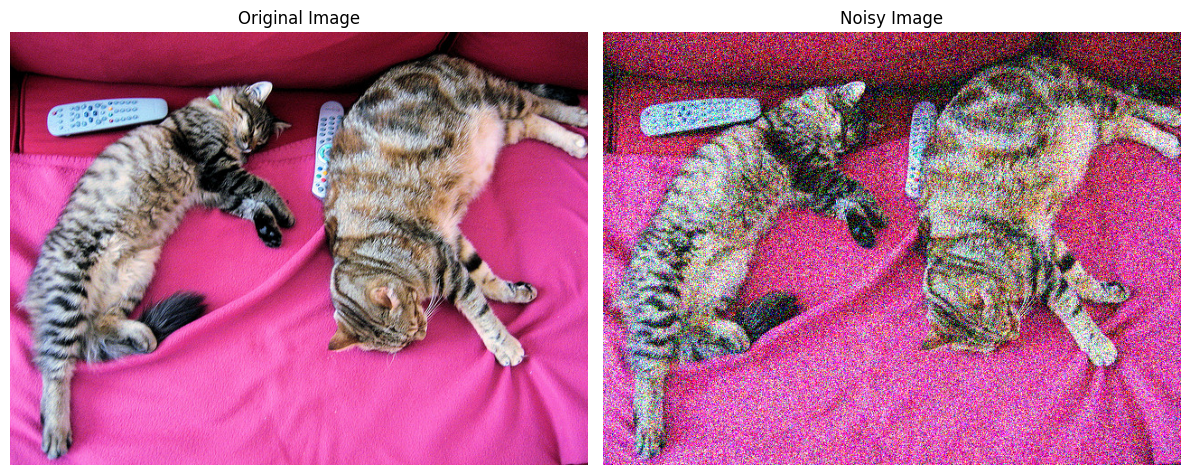

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(image, mean=0, std=75):
    # PIL 이미지를 numpy 배열로 변환
    image_array = np.asarray(image).astype(np.float32)

    # 가우시안 노이즈 생성
    noise = np.random.normal(mean, std, image_array.shape)

    # 노이즈 추가 및 클리핑
    noisy_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)

    # numpy 배열을 다시 PIL 이미지로 변환
    return Image.fromarray(noisy_image)

# 노이즈 추가
noisy_image = add_gaussian_noise(image)

# 원본 이미지와 노이즈 이미지 나란히 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title("Original Image")

# 노이즈 추가된 이미지
ax[1].imshow(noisy_image)
ax[1].axis("off")
ax[1].set_title("Noisy Image")

plt.tight_layout()
plt.show()

In [31]:
# Use CLIP to compute similarity scores for predefined captions
candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
inputs = modified_clip_processor(text=candidate_captions, images=noisy_image, return_tensors="pt", padding=True)
outputs = modified_clip_model(**inputs)

# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")

####################################################################################################
# CLIP 이미지 임베딩 추출
pixel_values = modified_clip_processor(images=noisy_image, return_tensors="pt").pixel_values
image_features = modified_clip_model.get_image_features(pixel_values)  # [batch_size, embedding_dim]

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
# generated_ids = caption_model.generate(pixel_values)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")


# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[22.6824, 23.8528, 23.5134]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a dog
Generated Caption: a cat laying on a blanket with a cat on it 
Generated Caption with CLIP influence: a photo of a dog and cat laying on a blanket 
